**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [29]:
%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.algorithm = algorithm
        self.n_neighbors = n_neighbors
        self.metric = metric

    def kneighbors(self, X, return_distance=True):

        if self.algorithm == 'brute':
            # does not support sparse
            # distances = distance.cdist(self._X, X, 'minkowski', p=2.)

            distances = pairwise_distances(self._X, X, self.metric)

            ind = distances.argsort(axis=0)
            ind = ind[:self.n_neighbors]
            distances = np.take_along_axis(distances, ind, axis=0)

        elif self.algorithm == 'kd_tree':

            # TODO: metric
            distances, ind = self._tree.query(
                X, self.n_neighbors)
            distances, ind = distances.T, ind.T  # FIXME: hack

        return distances, ind

    def fit(self, X, y):
        self._y = y
        self._X = X
        self._classes = np.unique(y_train)

        if self.algorithm == 'kd_tree':
            self._tree = KDTree(X)
        else:
            pass  # TODO

    def predict(self, X):

        distances, ind = self.kneighbors(X)

        mode, count = stats.mode(self._y[ind], axis=0)

        return mode

    def predict_proba(self, X):

        distances, ind = self.kneighbors(X)

        probabilities = []
        for k in self._classes:
            probabilities.append((self._y[ind] == k).mean(axis=0))

        return np.array(probabilities).T

    def score(self, X, y):
        return (y == self.predict(X)).mean()


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [30]:
iris = datasets.load_iris()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [32]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [33]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [34]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [35]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [36]:
%time my_clf.fit(X_train, y_train)

Wall time: 1 ms


In [37]:
%time clf.predict(X_test)

Wall time: 3 ms


array([0, 1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 0, 2, 1, 0])

In [38]:
%time my_clf.predict(X_test)

Wall time: 3 ms


array([[0, 1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 0, 2, 1, 0]])

In [39]:
%time clf.predict_proba(X_test)

Wall time: 1e+03 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [40]:
%time my_clf.predict_proba(X_test)

Wall time: 1e+03 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [41]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [43]:
%time clf.fit(X_train, y_train)

Wall time: 7 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [44]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [45]:
%time clf.predict(X_test)

Wall time: 3 ms


array([1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 2, 0, 1, 0])

In [46]:
%time my_clf.predict(X_test)

Wall time: 2 ms


array([[1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 2, 2, 0, 1, 0]])

In [47]:
%time clf.predict_proba(X_test)

Wall time: 2 ms


array([[0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ]])

In [48]:
%time my_clf.predict_proba(X_test) # FIXME: slow

Wall time: 0 ns


array([[0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ]])

In [49]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [50]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [51]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [52]:
import re

def tokenize(data, target):
    # FIXME: underscores
    data_tok = [re.sub('[^0-9a-zA-Z]',' ', line.lower()).split() for line in data] 
    data_tok, target = zip(*[(d,t) for d,t in zip(data_tok,target) if d != []])
    return data_tok, np.array(target)

data_tok, target = tokenize(data, target)

In [53]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [54]:
unique_tokens = set()
_ = [unique_tokens.update(d) for d in data_tok]
len(unique_tokens)

98734

In [55]:
tokenizer = {tok: i for i,tok in enumerate(unique_tokens)}

In [57]:
from scipy.sparse import csr_matrix

indices, data = [], []
indptr = [0]
for doc_num, line in enumerate(data_tok):
    for word in line:
        index = tokenizer[word]
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
    
X = csr_matrix((data, indices, indptr), dtype=int)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [58]:
from sklearn.model_selection import KFold
from tqdm import tqdm

def validate(estimator, X, y, folds=3):

    kf = KFold(n_splits=folds)
    kf.get_n_splits(X)
    
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        estimator.fit(X_train, y_train)
        score = estimator.score(X_test, y_test)
        scores.append(score)
    return np.array(scores)

In [59]:
validate(MyKNeighborsClassifier(n_neighbors=5, algorithm='brute'), X, target)

array([0.19411123, 0.19411123, 0.19683751])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [61]:
scores = []

for k in tqdm(range(1,11)):
    
    scores.append(
        validate(MyKNeighborsClassifier(n_neighbors=k, algorithm='brute'), X, target).mean()
    )
print(np.array(scores).mean())

100%|██████████████████████████████████████████| 10/10 [03:13<00:00, 20.07s/it]


0.19980916030534351


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [62]:
scores_cosine = []

for k in tqdm(range(1,11)):
    
    score = validate(MyKNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='cosine'), X, target).mean()
    scores_cosine.append(score)
    
print(np.array(scores_cosine).mean())

100%|██████████████████████████████████████████| 10/10 [03:45<00:00, 22.52s/it]


0.2653126135950563


TD-IDF

In [63]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(
    norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False
)

X_tfidf = tfidf.fit_transform(X)

In [64]:
scores_tfidf = []

for k in tqdm(range(1,11)):
    
    score = validate(MyKNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='euclidean'), X_tfidf, target).mean()
    scores_tfidf.append(score)
    
print(np.array(scores_tfidf).mean())

100%|██████████████████████████████████████████| 10/10 [03:24<00:00, 20.47s/it]


0.6185568884042166


In [65]:
scores_tfidf_cosine = []

for k in tqdm(range(1,11)):
    
    score = validate(MyKNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='cosine'), X_tfidf, target).mean()
    scores_tfidf_cosine.append(score)
    
print(np.array(scores_tfidf_cosine).mean())

100%|██████████████████████████████████████████| 10/10 [03:21<00:00, 19.34s/it]


0.6186114140312614


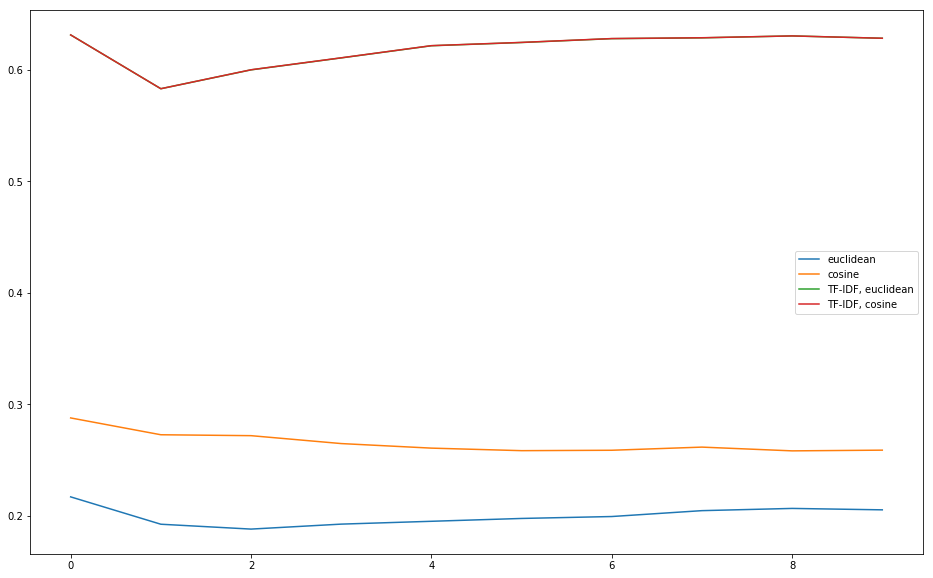

In [66]:
plt.figure(figsize=(16,10))

plt.plot(scores, label='euclidean')
plt.plot(scores_cosine, label='cosine')
plt.plot(scores_tfidf, label='TF-IDF, euclidean')
plt.plot(scores_tfidf_cosine, label='TF-IDF, cosine')

plt.legend()

In [107]:
results_staked = np.stack([scores, scores_cosine, scores_tfidf, scores_tfidf_cosine])
max_index = np.unravel_index(results_staked.argmax(), results_staked.shape)
print(f'max_index {max_index}, max value: {results_staked[max_index]:.6f}')

max_index (2, 0), max value: 0.631225


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [67]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [77]:
data_test = newsgroups['data']
target_test = newsgroups['target']

date_test_tok, target_test = tokenize(data_test, target_test)

from scipy.sparse import csr_matrix

indices, data = [], []
indptr = [0]
for doc_num, line in enumerate(date_test_tok):
    for word in line:
        index = tokenizer.get(word)
        if index is None:
            continue
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
    
X_test = csr_matrix((data, indices, indptr), dtype=int, shape=(len(date_test_tok), X.shape[1]))

In [78]:
X.shape, X_test.shape

((11004, 98734), (7309, 98734))

In [82]:
X_tfidf_test = tfidf.transform(X_test)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [86]:
best_model = MyKNeighborsClassifier(n_neighbors=1, metric='cosine')

model.fit(X_tfidf, target)
test_score = model.score(X_tfidf_test, target_test)

In [87]:
val_score = validate(best_model, X_tfidf, target).mean()

In [96]:
print(f'Test score: {test_score:.6f}\nVal score : {val_score:.6f}')

Test score: 0.541251
Val score : 0.631225


**Ответ**. Качество на тестовой выборке и на кросс-валидации заметно отличается. Скорее всего, модель переобучается на тренировочной выборке